In [25]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

from Models import tcn
from train.Dataset import CustomDataset
from train.TrainHelpers import train_model, plot_loss_graph, encode_data, train_svm
from train.TestHelpers import test_model, calculate_accuracy

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps") 
else:
    device = torch.device("cpu")
print(device)

cuda


In [2]:
### PARAMETERS ###
dataset_ver = '3w05s_Larm'
n_input = 9
n_hidden = 360
early_stop = True
patience = 5
dropout_rate = 0.2
num_epochs = 50
lr_rate = 1e-3
seed = 345

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

x_train = np.load(f'Generated_Datasets/train_data_{dataset_ver}.npy')
x_val = np.load(f'Generated_Datasets/val_data_{dataset_ver}.npy')
x_test = np.load(f'Generated_Datasets/test_data_{dataset_ver}.npy')

y_train = np.load(f'Generated_Datasets/train_labels_{dataset_ver}.npy')
y_val = np.load(f'Generated_Datasets/val_labels_{dataset_ver}.npy')
y_test = np.load(f'Generated_Datasets/test_labels_{dataset_ver}.npy')

(11578, 60, 9) (3308, 60, 9) (1654, 60, 9)


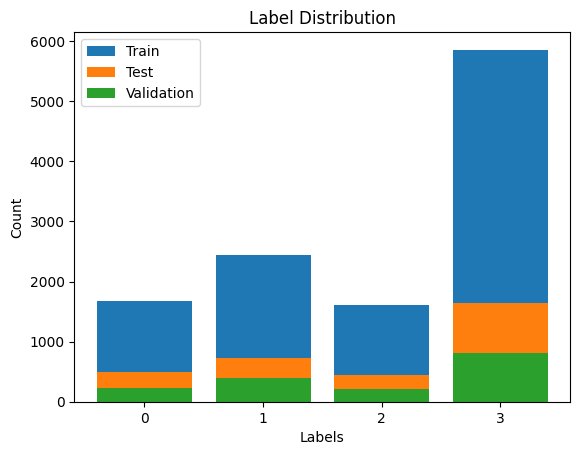

In [3]:
# Check Dataset
print(x_train.shape, x_test.shape, x_val.shape)
unique_labels_train, label_counts_train = np.unique(y_train, return_counts=True)
unique_labels_val, label_counts_val = np.unique(y_val, return_counts=True)
unique_labels_test, label_counts_test = np.unique(y_test, return_counts=True)

plt.bar(unique_labels_train, label_counts_train, label='Train')
plt.bar(unique_labels_test, label_counts_test, label='Test')
plt.bar(unique_labels_val, label_counts_val, label='Validation')

# Set the x-axis tick labels
plt.xticks(unique_labels_train, unique_labels_train)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.legend()
plt.show()

In [4]:
### Declare Dataloaders
train_dataset = CustomDataset("train", dataset_ver)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = CustomDataset("val", dataset_ver)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataset = CustomDataset("test", dataset_ver)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [5]:
# Bidirectional 1-Layer LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(Encoder, self).__init__()
        nb_filters = 64
        self.conv = nn.Conv1d(input_size, nb_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.LSTM1 = nn.LSTM(nb_filters, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_size = hidden_size

    def forward(self, x):
        x = x.permute(0, 2, 1)  # conv = (batch, no of channels, sequence length)
        x = self.conv(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # swap back
        x, (encoded_x, _) = self.LSTM1(x)
        x = self.dropout(encoded_x)
        return x[-1,:,:]

class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate):
        super(Decoder, self).__init__()
        nb_filters = 64
        self.hidden_size = hidden_size
        self.conv = nn.Conv1d(hidden_size, nb_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.LSTM1 = nn.LSTM(nb_filters, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.output = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, 60, 1)
        x = x.permute(0, 2, 1)  # conv = (batch, no of channels, sequence length)
        x = self.conv(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # swap back
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size, dropout_rate).to(device)
        self.decoder = Decoder(hidden_size, in_out_size, dropout_rate).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential()

        for i in range(len(layer_sizes)-1):
            self.mlp.add_module(f'fc{i+1}', nn.Linear(layer_sizes[i], layer_sizes[i+1]))

    def forward(self, x):
        return self.mlp(x)

In [9]:
mlp_classifier = MLP([360, 64, 16, 4])
print(mlp_classifier)

MLP(
  (mlp): Sequential(
    (fc1): Linear(in_features=360, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=4, bias=True)
  )
)


Autoencoder(
  (encoder): Encoder(
    (conv): Conv1d(9, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (conv): Conv1d(360, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0259, Val Loss: 0.0403
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0304, Val Loss: 0.0378
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0220, Val Loss: 0.0224
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0142, Val Loss: 0.0166
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0150, Val Loss: 0.0148
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0146, Val Loss: 0.0130
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0086, Val Loss: 0.0120
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0137, Val Loss: 0.0140
ES_Counter: 1
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0116, Val Loss: 0.0112
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0130, Val Loss: 0.0111
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0100, Val Loss: 0.0102
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0119, Val Loss: 0.0108
ES_Counter: 1
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0158, Val Loss: 0.0093
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0089, Val Loss: 0.0096
ES_Counter: 1
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0109, Val Loss: 0.0086
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0099, Val Loss: 0.0086
ES_Counter: 1
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0096, Val Loss: 0.0082
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0126, Val Loss: 0.0085
ES_Counter: 1
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0098, Val Loss: 0.0081
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0075, Val Loss: 0.0078
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0091, Val Loss: 0.0076
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0092, Val Loss: 0.0080
ES_Counter: 1
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0077, Val Loss: 0.0072
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0054, Val Loss: 0.0071
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0056, Val Loss: 0.0071
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0078, Val Loss: 0.0073
ES_Counter: 1
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0087, Val Loss: 0.0089
ES_Counter: 2
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0109, Val Loss: 0.0071
ES_Counter: 3
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0077, Val Loss: 0.0068
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0082, Val Loss: 0.0067
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0081, Val Loss: 0.0064
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0100, Val Loss: 0.0065
ES_Counter: 1
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0061, Val Loss: 0.0069
ES_Counter: 2
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0084, Val Loss: 0.0063
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0086, Val Loss: 0.0063
ES_Counter: 1
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0068, Val Loss: 0.0061
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0063, Val Loss: 0.0068
ES_Counter: 1
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0050, Val Loss: 0.0067
ES_Counter: 2
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0072, Val Loss: 0.0061
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0074, Val Loss: 0.0062
ES_Counter: 1
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0054, Val Loss: 0.0061
ES_Counter: 2
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0055, Val Loss: 0.0059
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0098, Val Loss: 0.0060
ES_Counter: 1
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0045, Val Loss: 0.0059
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0061, Val Loss: 0.0060
ES_Counter: 1
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0059, Val Loss: 0.0058
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0060, Val Loss: 0.0060
ES_Counter: 1
Starting Epoch 48...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0066, Val Loss: 0.0056
Starting Epoch 49...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0064, Val Loss: 0.0056
Starting Epoch 50...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0048, Val Loss: 0.0055


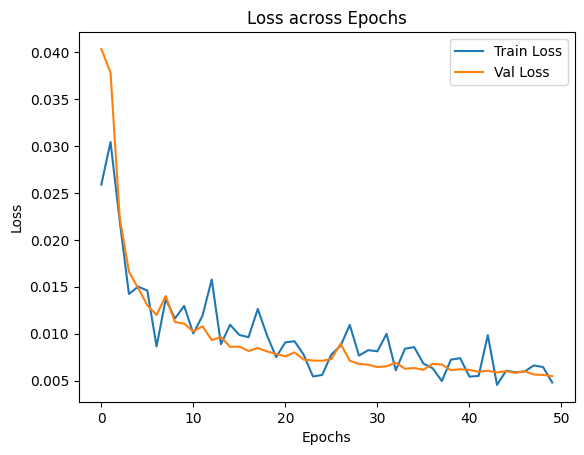

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])


In [8]:
tag = '1CNN_1LSTMBD'
encoder_ver = f'{n_hidden}h{num_epochs}e{dropout_rate}dr{lr_rate}lr'
train_losses, val_losses = train_model(Autoencoder, train_dataloader, val_dataloader, val_dataset, n_input, n_hidden, dataset_ver, encoder_ver, tag, early_stop, dropout_rate, num_epochs, lr_rate)
plot_loss_graph(train_losses, val_losses, tag)
encoded_data, labels = encode_data(train_dataloader, dataset_ver, tag, encoder_ver)



In [31]:
enc_X_train, enc_X_val, enc_y_train, enc_y_val = train_test_split(encoded_data, labels, test_size=0.2, random_state=42)

print(f'{enc_X_train.shape=}, {enc_y_train.shape=}')
print(f'{enc_X_val.shape=}, {enc_y_val.shape=}')

encoded_dataset_train = TensorDataset(enc_X_train, enc_y_train)
encoded_dataloader_train = DataLoader(encoded_dataset_train, batch_size=1, shuffle=True)

encoded_dataset_val = TensorDataset(enc_X_val, enc_y_val)
encoded_dataloader_val = DataLoader(encoded_dataset_val, batch_size=1, shuffle=True)

enc_X_train.shape=torch.Size([9262, 360]), enc_y_train.shape=torch.Size([9262, 1])
enc_X_val.shape=torch.Size([2316, 360]), enc_y_val.shape=torch.Size([2316, 1])


In [32]:
def train_MLP(model, learning_rate, num_epochs, patience):
    optimizer = optim.Adam(model.parameters(),
                            lr=learning_rate,
                            betas=(0.9, 0.999),
                            eps=1e-8)

    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    best_val_acc = 0
    es_count = 0

    for epoch in range(num_epochs):
        if es_count < patience:
            print(f'Starting Epoch {epoch+1}...')
            model.train()

            train_preds = []
            train_labels = []

            for train_X, train_y in tqdm(encoded_dataloader_train):
                optimizer.zero_grad()
                
                train_output = model(train_X)

                train_loss = criterion(train_output, train_y[0].type(torch.LongTensor))
                train_loss.backward()
                optimizer.step()

                train_preds.append(torch.argmax(train_output))
                train_labels.append(train_y)
            
            train_losses.append(train_loss.item())
            print(f'Train Loss = {train_losses[-1]}')

            train_acc = accuracy_score(train_labels, train_preds)
            print(f'Train Acc = {train_acc}')

            model.eval()

            val_preds = []
            val_labels = []

            for val_X, val_y in tqdm(encoded_dataloader_val):
                val_output = model(val_X)

                val_preds.append(torch.argmax(val_output))
                val_labels.append(val_y)

            val_losses.append(criterion(val_output, val_y[0].type(torch.LongTensor)))
            print(f'Val Loss = {val_losses[-1]}')

            val_acc = accuracy_score(val_labels, val_preds)
            print(f'Val Acc = {val_acc}')

            if val_acc > best_val_acc:
                torch.save(deepcopy(model.state_dict()), 'ML_Models/noncausal_tcn_state_20e.pt')
                best_val_acc = val_acc
                es_count = 0
            
            es_count += 1
        
        else:
            print('Early Stopping...')

    return train_losses, val_losses

In [33]:
train_MLP(mlp_classifier, 1e-3, 50, 5)

Starting Epoch 1...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.02879832312464714


ValueError: Classification metrics can't handle a mix of unknown and multiclass targets